In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sympy as sp
import matplotlib.gridspec as gridspec
import random
from importlib import reload # python 2.7 does not require this
import models
reload(models)
from models import FNOProjected, ml_predictor_rnn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch
import time
from tabulate import tabulate

In [3]:
def dynamics(state, control):
    return np.array([control[0]*math.cos(state[2]), control[0]*math.sin(state[2]), control[1]])

def controller(state, t):
    p = state[0]*math.cos(state[2])+state[1]*math.sin(state[2])
    q = state[0]*math.sin(state[2])-state[1]*math.cos(state[2])
    omega = -5*p**2*math.cos(3*t) - p*q*(1+25*math.cos(3*t)*math.cos(3*t))-state[2]
    nu = -p+5*q*math.sin(3*t)-math.cos(3*t) + q*omega
    return np.array([nu, omega])

def predictor_const_delay(cur_state, control_history, D, x):
    nx = len(x)
    integral_tmp = np.zeros((nx, 3))
    res = np.zeros((nx, 3))
    res[0] = np.copy(cur_state)
    for i in range(1, nx):
        integral_tmp[i] = dynamics(res[i-1], control_history[i-1]) 
        res[i] = res[0] + D*np.array([np.trapz(integral_tmp[0:i+1, 0], x=x[0:i+1]), \
                                      np.trapz(integral_tmp[0:i+1, 1], x=x[0:i+1]),\
                                      np.trapz(integral_tmp[0:i+1, 2], x=x[0:i+1])])
    return res

def predictor_non_const_delay(cur_state, control_history, D, x):
    nx = len(x)
    integral_tmp = np.zeros((nx, 3))
    res = np.zeros((nx, 3))
    res[0] = np.copy(cur_state)
    for i in range(1, nx):
        integral_tmp[i] = dynamics(res[i-1], control_history[i-1]) 
        res[i] = res[0] + D*np.array([np.trapz(integral_tmp[0:i+1, 0], x=x[0:i+1]), \
                                      np.trapz(integral_tmp[0:i+1, 1], x=x[0:i+1]),\
                                      np.trapz(integral_tmp[0:i+1, 2], x=x[0:i+1])])
    return res[-1]

def simulate_system(init_cond, dt, T):
    t = np.arange(0, T, dt)
    u = np.zeros((len(t), 3))
    u[0] = init_cond
    controls = np.zeros((len(t), 2))
    for i in range(1, len(t)):
        control = controller(u[i-1], t[i-1])
        u[i] = u[i-1] + dt*dynamics(u[i-1], control)
        controls[i] = control
    return u, controls

def simulate_system_const_delay(init_cond, dt, T, dx, D):
    t = np.arange(0, T, dt)
    x = np.arange(0, 1, dx)
    nx = len(x)
    nt = len(t)
    u = np.zeros((nt, 3))
    pde_sol = np.zeros((nt, nx, 2))
    controls = np.zeros((nt, 2))
    predictions = np.zeros((nt, nx, 3))
    u[0] = init_cond
    for i in range(1, nt):
        prediction = predictor_const_delay(u[i-1], pde_sol[i-1], D, x)
        predictions[i-1] = prediction
        pde_sol[i][0:nx-1] = pde_sol[i-1][0:nx-1] + dt/(D*dx) * (pde_sol[i-1][1:nx] - pde_sol[i-1][0:nx-1])
        pde_sol[i][-1] = controller(prediction[-1], t[i-1]+D)
        u[i] = u[i-1] + dt*dynamics(u[i-1], pde_sol[i][0])
        controls[i] = pde_sol[i][0]
    return u, controls, pde_sol, predictions

def simulate_system_const_delay_neural_op(init_cond, dt, T, dx, D, model, predictor_func):
    t = np.arange(0, T, dt)
    x = np.arange(0, 1, dx)
    nx = len(x)
    nt = len(t)
    u = np.zeros((nt, 3))
    pde_sol = np.zeros((nt, nx, 2))
    controls = np.zeros((nt, 2))
    predictions = np.zeros((nt, nx, 3))
    u[0] = init_cond
    for i in range(1, nt):
        prediction = predictor_func(u[i-1], pde_sol[i-1], D, x, model)
        predictions[i-1] = prediction
        pde_sol[i][0:nx-1] = pde_sol[i-1][0:nx-1] + dt/(D*dx) * (pde_sol[i-1][1:nx] - pde_sol[i-1][0:nx-1])
        pde_sol[i][-1] = controller(prediction[-1], t[i-1]+D)
        u[i] = u[i-1] + dt*dynamics(u[i-1], pde_sol[i][0])
        controls[i] = pde_sol[i][0]
    return u, controls, pde_sol, predictions

def simulate_system_non_const_delay(init_cond, dt, T, dx, delay_funcs):
    phi_inv, phi_inv_deriv = delay_funcs[0], delay_funcs[1]
    t = np.arange(0, T, dt)
    x = np.arange(0, 1, dx)
    nx = len(x)
    nt = len(t)
    u = np.zeros((nt, 3))
    pde_sol = np.zeros((nt, nx, 2))
    controls = np.zeros((nt, 2))
    u[0] = init_cond
    for i in range(1, nt):
        prediction = predictor_non_const_delay(u[i-1], pde_sol[i-1], phi_inv(t[i-1])-t[i-1], x)
        pi = (1+x[0:nx-1]*(phi_inv_deriv(t[i-1])-1)/(phi_inv(t[i-1])-t[i-1]))
        pde_sol[i][0:nx-1] = pde_sol[i-1][0:nx-1] + dt/dx * np.tile(pi[:, np.newaxis], (1, 2))\
                                                             *(pde_sol[i-1][1:nx] - pde_sol[i-1][0:nx-1])
        pde_sol[i][-1] = controller(prediction, t[i-1]+D)
        u[i] = u[i-1] + dt*dynamics(u[i-1], pde_sol[i][0])
        controls[i] =  pde_sol[i][0]
    return u, controls

In [4]:
init_cond = [2, 2, 2]
dt = 0.01
T = 10
D = 2
dx = 0.01

# Define the symbolic variable
t = sp.symbols('t')

# Define the original symbolic expression
phi_inv_expr = t + (t + 1) / (sp.sqrt((t + 1)**2 + 1) + t)

# Compute the symbolic derivative
phi_inv_derivative_expr = sp.diff(phi_inv_expr, t)

# Convert both expressions into callable functions
phi_inv = sp.lambdify(t, phi_inv_expr, modules=['numpy'])
phi_inv_deriv = sp.lambdify(t, phi_inv_derivative_expr, modules=['numpy'])    

#u, control = simulate_system(init_cond, dt, T)
u_delay, control_delay, _, _ = simulate_system_const_delay(init_cond, dt, T, dx, D)
#u_non_const_delay, control_non_const_delay = simulate_system_non_const_delay(init_cond, dt, T, dx, (phi_inv, phi_inv_deriv))

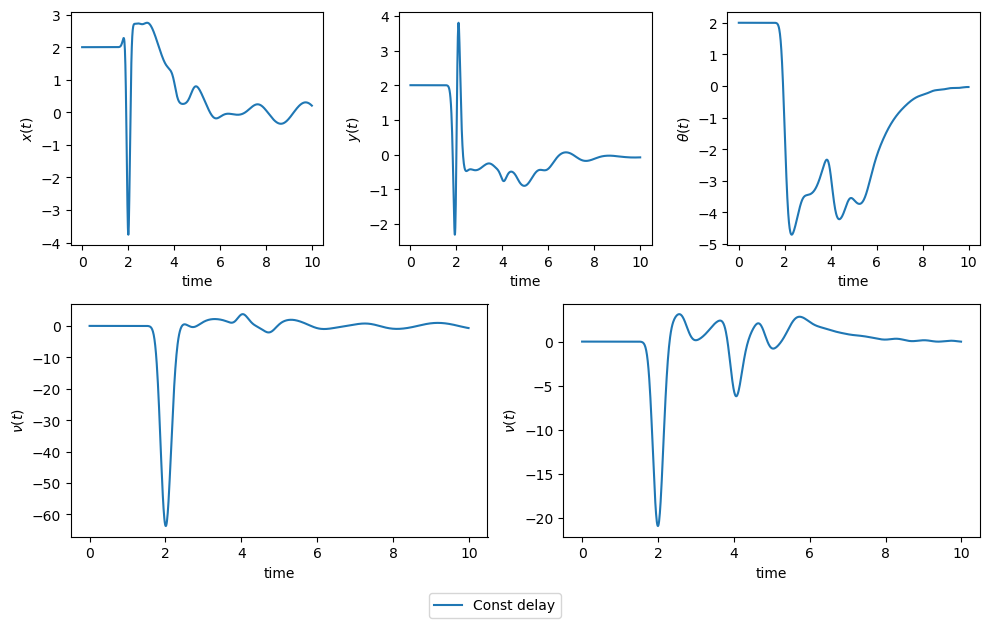

In [6]:
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 6, height_ratios=[1, 1])  # 2 rows, 3 columns

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])

ax4 = fig.add_subplot(gs[1, 0:3])  # Spans columns 0 and 1
ax5 = fig.add_subplot(gs[1, 3:6])    # Just column 2

t = np.arange(0, T, dt)

ax1.plot(t, u_delay[:, 0], label="Const delay")
ax1.set_ylabel(r"$x(t)$")
ax1.set_xlabel("time")

ax2.plot(t, u_delay[:, 1], label="Const delay")
ax2.set_ylabel(r"$y(t)$")
ax2.set_xlabel("time")


ax3.plot(t,u_delay[:, 2], label="Const delay")
ax3.set_xlabel("time")
ax3.set_ylabel(r"$\theta(t)$")

ax4.plot(t,control_delay[:, 0], label="Const delay")
ax4.set_xlabel("time")
ax4.set_ylabel(r"$\nu(t)$")


l2, = ax5.plot(t, control_delay[:, 1], label="Const delay")
ax5.set_xlabel("time")
ax5.set_ylabel(r"$\nu(t)$")

# Horizontal legend below all plots
fig.legend(handles=[ l2],
           loc='lower center',
           ncol=3,
           fontsize=10,
           frameon=True,
           fancybox=True,
           shadow=False,
           bbox_to_anchor=(0.5, -0.05))  # Adjust this to fine-tune spacing

plt.tight_layout(rect=[0, 0.08, 1, 1])  # Leave space at bottom for legend 

plt.tight_layout()

In [41]:
# Build a dataset for unicycle for const delay. Vary over both initial conditions and delay
num_trajs = 100
sample_rate = 200
dt = 0.01torch.optim.lr_scheduler.ExponentialLRtorch.optim.lr_scheduler.ExponentialLR
T = 15
D = 1
dx = 0.01
x = np.arange(0, 1, dx)
nx = len(x)
t = np.arange(0, T, dt)
nt = len(t)torch.optim.lr_scheduler.ExponentialLR
index = 0

inputs = np.zeros((num_trajs*sample_rate, nx, 6))
outputs = np.zeros((num_trajs*sample_rate, nx, 3))
for i in range(num_trajs):
    if i % 5 == 0:
        print(i)
    init_cond = np.array([1, 1, 1]) + np.random.uniform(0, 0.5, size=3)
    D = np.random.uniform(1, 1.1)
    u_delay, control_delay, pde, predictions = simulate_system_const_delay(init_cond, dt, T, dx, D)
    sample_locs = random.sample(range(0, nt), sample_rate)
    for sample in sample_locs:
        delays = np.full(nx, D).reshape(nx, 1)
        states = np.tile(u_de
Skip to Main
UnicycleConstDelay
Last Checkpoint: 39 minutes ago
[Python 3 (ipykernel)]
import numpy as np
import matplotlib.pyplot as plt
import math
import sympy as sp
import matplotlib.gridspec as gridspec
import random
lay[sample], (nx, 1))
        inputs[index] = np.hstack([delays, states, pde[sample]])
        outputs[index] = predictions[sample]
        index += 1

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


In [42]:
np.save('inp_dataset_const.npy', inputs)
np.save('out_dataset_const.npy', outputs)

In [9]:
batch_size=128

In [10]:
inputs = np.load("inp_dataset_const.npy").astype(np.float32)
outputs = np.load("out_dataset_const.npy").astype(np.float32)

x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_train = torch.from_numpy(y_train).cuda()
y_test = torch.from_numpy(y_test).cuda()
torch.optim.lr_scheduler.ExponentialLR
trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device="cuda"))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device="cuda"))

In [12]:
def model_trainer(model, trainData, testData, num_epochs, batch_size, gamma, learning_rate, weight_decay):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    loss = torch.nn.MSELoss(reduction="mean")
    best_test_loss = np.inf
    train_lossArr = []
    test_lossArr = []
    time_Arr = []
    print("Epoch", "Time", "Train Loss", "Test Loss")
    print("Total epochs", num_epochs)
    for ep in range(num_epochs):
        model.train()
        t1 = time.time()
        train_loss = 0
        for x_vals, y_vals in trainData:
            optimizer.zero_grad()
            out = model(x_vals)
        
            lp = loss(out, y_vals) 
            lp.backward()
            
            optimizer.step()
            train_loss += lp.item()
            
        scheduler.step()
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x_vals, y_vals in testData:
                out = model(x_vals)
                test_loss += loss(out, y_vals).item() 

        train_loss /= len(trainData)
        test_loss /= len(testData)
        
        train_lossArr.append(train_loss)
        test_lossArr.append(test_loss)
        
        t2 = time.time()
        time_Arr.append(t2-t1)
        if ep%5 == 0:
            print(ep, t2-t1, train_loss, test_loss)

        if test_loss <= best_test_loss:
            bestModelDict = model.state_dict()
            best_test_loss = test_loss
    torch.save(bestModelDict,"myModel")
    return model, train_lossArr, test_lossArr
    
def evaluate_model(model, name, train_lossArr, test_lossArr):
    print("Evaluating model", name)
    # Display Model Details
    plt.figure()
    plt.title("Loss function "+name)
    plt.plot(train_lossArr, label="Train Loss")
    plt.plot(test_lossArr, label="Test Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.savefig("losscurve.pdf")
        
    print("Final Testing Loss:", test_lossArr[-1])
    print("Final Training Loss:", train_lossArr[-1])

In [21]:
model = FNOProjected(16,2, 12,6,3)

Epoch Time Train Loss Test Loss
Total epochs 50
0 0.9571352005004883 0.04062511879580875 0.015185449155978858
5 0.6161863803863525 0.00039415583877282624 0.0003692366954055615
10 0.6164817810058594 0.00025735622567474737 0.00025861513586278306
15 0.6187691688537598 0.00021847221997883568 0.0002256825737276813
20 0.6120293140411377 0.00019896780406967045 0.00020977292024326744
25 0.6132056713104248 0.0001864228759857608 0.0001959973687917227
30 0.6433730125427246 0.00017934913730706213 0.00018873591761803254
35 0.622316837310791 0.00017345897421564458 0.0001838681255321717
40 0.6197376251220703 0.00017012338111084614 0.00018069171164825093
45 0.6190409660339355 0.00016764914404339957 0.000178412993591337
Evaluating model FNO


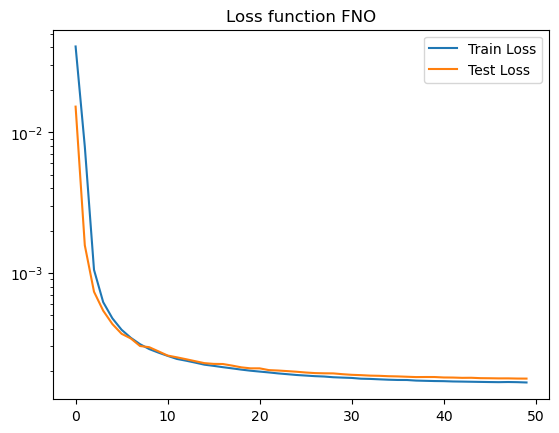

Final Testing Loss: 0.00017737705002218718
Final Training Loss: 0.00016648583886121128


<Figure size 640x480 with 0 Axes>

In [22]:
batch_size=128
gamma=0.9
lr=1e-3
decay=1e-4
epochs=50
model, trainLoss, testLoss = model_trainer(model, trainData, testData, epochs, batch_size, gamma, lr, decay)
evaluate_model(model, "FNO", trainLoss, testLoss)

In [23]:
init_cond = [1,1,1]
dt = 0.01
T = 10
D = 1
dx = 0.01

u_delay, control_delay, _, _ = simulate_system_const_delay(init_cond, dt, T, dx, D)
u_delay_ml, control_delay_ml, _, _ = simulate_system_const_delay_neural_op(init_cond, dt, T, dx, D, model,  ml_predictor_rnn)

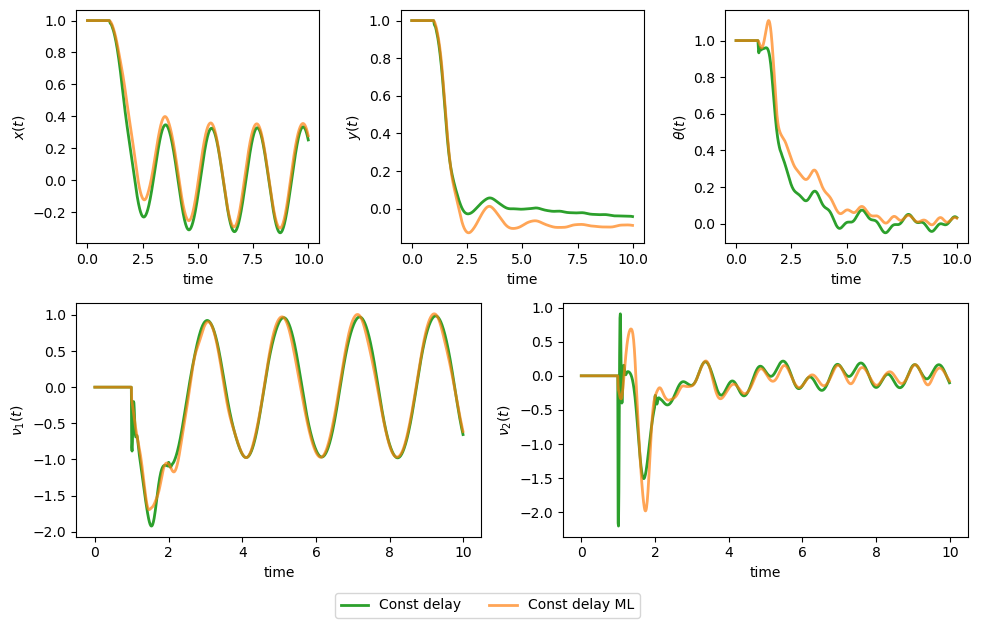

In [24]:
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 6, height_ratios=[1, 1])  # 2 rows, 3 columns

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])

ax4 = fig.add_subplot(gs[1, 0:3])  # Spans columns 0 and 1
ax5 = fig.add_subplot(gs[1, 3:6])    # Just column 2

t = np.arange(0, T, dt)

style1 = {'color': 'tab:green', 'linestyle': '-', 'linewidth': 2}
style2 = {'color': 'tab:orange', 'linestyle': '-', 'linewidth': 2, 'alpha': 0.7}

ax1.plot(t, u_delay[:, 0], label="Const delay", **style1)
ax1.plot(t, u_delay_ml[:, 0], label="Const delay ML", **style2)
ax1.set_ylabel(r"$x(t)$")
ax1.set_xlabel("time")

ax2.plot(t, u_delay[:, 1], **style1)
ax2.plot(t, u_delay_ml[:, 1], **style2)
ax2.set_ylabel(r"$y(t)$")
ax2.set_xlabel("time")

ax3.plot(t, u_delay[:, 2], **style1)
ax3.plot(t, u_delay_ml[:, 2], **style2)
ax3.set_xlabel("time")
ax3.set_ylabel(r"$\theta(t)$")

ax4.plot(t, control_delay[:, 0], **style1)
ax4.plot(t, control_delay_ml[:, 0], **style2)
ax4.set_xlabel("time")
ax4.set_ylabel(r"$\nu_1(t)$")

l1, = ax5.plot(t, control_delay[:, 1], label="Const delay", **style1)
l2, = ax5.plot(t, control_delay_ml[:, 1], label="Const delay ML", **style2)
ax5.set_xlabel("time")
ax5.set_ylabel(r"$\nu_2(t)$")

# Add a horizontal legend below all subplots
fig.legend(handles=[l1, l2],
           loc='lower center',
           ncol=3,
           fontsize=10,
           frameon=True,
           fancybox=True,
           shadow=False,
           bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()

In [27]:
# Get speedups across both Delay length and dt
model = FNOProjected(16,2, 12,6,3)
num_sims = 1000
# dt = 0.01
# dt = 0.005
# dt = 0.001
# dt = 0.0005
start_times_numerical = np.zeros((4))
end_times_numerical = np.zeros((4))
start_times_ml = np.zeros((4))
end_times_ml = np.zeros((4))

# D=1, dt=0.01
D = 1
dt = 0.01
x = np.arange(0, 1, dt)
cur_state = np.random.uniform(size=3)
start_times_numerical[0] = time.time()
for i in range(num_sims):
    cur_state = np.random.uniform(size=3)
    control_inp = np.random.uniform(size=(len(x), 2))
    predictor_const_delay(cur_state, control_inp, D, x)
end_times_numerical[0] = time.time()

start_times_ml[0] = time.time()
for i in range(num_sims):
    cur_state = np.random.uniform(size=3)
    control_inp = np.random.uniform(size=(len(x), 2))
    ml_predictor_rnn(cur_state, control_inp, D, x, model)
end_times_ml[0] = time.time()

# D=1, dt=0.005
D = 1
dt = 0.005
x = np.arange(0, 1, dt)
cur_state = np.random.uniform(size=3)
start_times_numerical[1] = time.time()
for i in range(num_sims):
    cur_state = np.random.uniform(size=3)
    control_inp = np.random.uniform(size=(len(x), 2))
    predictor_const_delay(cur_state, control_inp, D, x)
end_times_numerical[1] = time.time()

start_times_ml[1] = time.time()
for i in range(num_sims):
    cur_state = np.random.uniform(size=3)
    control_inp = np.random.uniform(size=(len(x), 2))
    ml_predictor_rnn(cur_state, control_inp, D, x, model)
end_times_ml[1] = time.time()

# D=1, dt=0.001
D = 1
dt = 0.001
x = np.arange(0, 1, dt)
cur_state = np.random.uniform(size=3)
start_times_numerical[2] = time.time()
for i in range(num_sims):
    cur_state = np.random.uniform(size=3)
    control_inp = np.random.uniform(size=(len(x), 2))
    predictor_const_delay(cur_state, control_inp, D, x)
end_times_numerical[2] = time.time()

start_times_ml[2] = time.time()
for i in range(num_sims):
    cur_state = np.random.uniform(size=3)
    control_inp = np.random.uniform(size=(len(x), 2))
    ml_predictor_rnn(cur_state, control_inp, D, x, model)
end_times_ml[2] = time.time()

# D=1, dt=0.001
D = 1
dt = 0.0005
x = np.arange(0, 1, dt)
cur_state = np.random.uniform(size=3)
start_times_numerical[3] = time.time()
for i in range(num_sims):
    cur_state = np.random.uniform(size=3)
    control_inp = np.random.uniform(size=(len(x), 2))
    predictor_const_delay(cur_state, control_inp, D, x)
end_times_numerical[3] = time.time()

start_times_ml[3] = time.time()
for i in range(num_sims):
    cur_state = np.random.uniform(size=3)
    control_inp = np.random.uniform(size=(len(x), 2))
    ml_predictor_rnn(cur_state, control_inp, D, x, model)
end_times_ml[3] = time.time()

In [28]:
times_numerical = end_times_numerical - start_times_numerical
times_ml = end_times_ml - start_times_ml

# Labels
col_labels = ["dt=0.01", "dt=0.005", "dt=0.001", "dt=0.0005"]

# Combine row labels with matrix data

# Print pretty table
print("Numerical times")
formatted_row = [[f"{val:.2f}" for val in times_numerical]]
print(tabulate(formatted_row, headers=col_labels, tablefmt="grid"))

print("Ml times")
formatted_row = [[f"{val:.2f}" for val in times_ml]]
print(tabulate(formatted_row, headers=col_labels, tablefmt="grid"))

print("Speedup")
formatted_row = [[f"{val:.2f}" for val in times_numerical/times_ml]]
print(tabulate(formatted_row, headers=col_labels, tablefmt="grid"))

Numerical times
+-----------+------------+------------+-------------+
|   dt=0.01 |   dt=0.005 |   dt=0.001 |   dt=0.0005 |
+===========+============+============+=============+
|      1.99 |       4.12 |      23.09 |       50.43 |
+-----------+------------+------------+-------------+
Ml times
+-----------+------------+------------+-------------+
|   dt=0.01 |   dt=0.005 |   dt=0.001 |   dt=0.0005 |
+===========+============+============+=============+
|       1.1 |       1.11 |       1.23 |        1.48 |
+-----------+------------+------------+-------------+
Speedup
+-----------+------------+------------+-------------+
|   dt=0.01 |   dt=0.005 |   dt=0.001 |   dt=0.0005 |
+===========+============+============+=============+
|      1.81 |       3.72 |      18.76 |       34.18 |
+-----------+------------+------------+-------------+
